# Datathon - Reto 2
## Análisis de sentimiento
NLP con transfer learning mediante el modelo BERT

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, f1_score, accuracy_score
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub
from matplotlib import pyplot as plt
import seaborn as sns

2023-03-26 08:35:22.821832: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 08:35:22.880333: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-26 08:35:23.167354: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/jarroyo/miniconda3/envs/tf/lib/
2023-03-26 08:35:23.167386: W tensorflow/compiler/xla/strea

In [2]:
df = pd.read_csv('train.csv')
df

,train_idx,text,label,label_text
0,0,i really do recommend this to anyone in need o...,1,positive
1,1,very good every day camera fits nicely in the ...,1,positive
2,2,"but , dollar for dollar , this dvd player is p...",1,positive
3,3,i got this phone yesterday and didn ' t find a...,1,positive
4,4,1 ) price gb of storage,1,positive
...,...,...,...,...
3011,3011,"as for itunes , i don ' t find it to be as goo...",1,positive
3012,3012,"i have not played with all the features yet , ...",1,positive
3013,3013,applications it has lots of applications and t...,1,positive
3014,3014,battery non issue,1,positive


In [3]:
# Add description length to the dataset
df["text_len"] = df["text"].str.len()
df.head()

,train_idx,text,label,label_text,text_len
0,0,i really do recommend this to anyone in need o...,1,positive,60
1,1,very good every day camera fits nicely in the ...,1,positive,89
2,2,"but , dollar for dollar , this dvd player is p...",1,positive,72
3,3,i got this phone yesterday and didn ' t find a...,1,positive,69
4,4,1 ) price gb of storage,1,positive,23


In [4]:
df['label'].value_counts()

1    1926
0    1090
Name: label, dtype: int64

In [5]:
# Split dataset into train and test (these are datasets also)
train, test = train_test_split(df,
                               test_size = 0.2,
                               random_state=42)

In [6]:
# Required numpy arrays from the datasets for later computations
X_train = train['text'].to_numpy()
X_test = test['text'].to_numpy()

y_train = train['label'].to_numpy()
y_test = test['label'].to_numpy()

In [7]:
# Imbalanced dataset: Adjust class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)
class_weights_dict = dict(enumerate(class_weights))

In [8]:
class_weights_dict

{0: 1.372013651877133, 1: 0.786692759295499}

In [9]:
# Print some examples of the training set
X_train[:5]

array(['the interface took a little getting used to',
       'loved the slim design',
       'while the software may not be as easy as i tunes , it is not difficult to use by any stretch',
       "as for itunes , i don ' t find it to be as good as the windows media player as a computer mp3 player , but it is good enough",
       'i have it for a week now , and this camera has exceeded my expectations'],
      dtype=object)

In [10]:
# Bert preprocessing and pre-trained model
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name="BERT_preprocess")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", name="BERT_encoder")

2023-03-26 08:35:23.808357: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-26 08:35:23.812380: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-26 08:35:23.812464: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-26 08:35:23.812650: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuil

In [11]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 BERT_preprocess (KerasLayer)   {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [13]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [14]:
model.fit(X_train, y_train, epochs=20, batch_size = 32, class_weight=class_weights_dict)

Epoch 1/20
 1/76 [..............................] - ETA: 4:22 - loss: 0.7398 - accuracy: 0.6250

2023-03-26 08:35:31.898990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-26 08:35:31.925721: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f877c007810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-26 08:35:31.925733: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-03-26 08:35:31.928572: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-26 08:35:31.968925: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-03-26 08:35:31.968938: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas 

76/76 [==============================] - 7s 53ms/step - loss: 0.6848 - accuracy: 0.5721
Epoch 2/20
76/76 [==============================] - 4s 58ms/step - loss: 0.6678 - accuracy: 0.5763
Epoch 3/20
76/76 [==============================] - 4s 59ms/step - loss: 0.6363 - accuracy: 0.6410
Epoch 4/20
76/76 [==============================] - 5s 60ms/step - loss: 0.6171 - accuracy: 0.6824
Epoch 5/20
76/76 [==============================] - 5s 60ms/step - loss: 0.6060 - accuracy: 0.6779
Epoch 6/20
76/76 [==============================] - 4s 58ms/step - loss: 0.5867 - accuracy: 0.7127
Epoch 7/20
76/76 [==============================] - 4s 59ms/step - loss: 0.5770 - accuracy: 0.7260
Epoch 8/20
76/76 [==============================] - 4s 59ms/step - loss: 0.5606 - accuracy: 0.7376
Epoch 9/20
76/76 [==============================] - 5s 60ms/step - loss: 0.5540 - accuracy: 0.7409
Epoch 10/20
76/76 [==============================] - 4s 59ms/step - loss: 0.5444 - accuracy: 0.7359
Epoch 11/20
76/76 [=

In [15]:
model.evaluate(X_test, y_test)

19/19 [==============================] - 1s 58ms/step - loss: 0.4626 - accuracy: 0.8212


[0.4625716507434845, 0.8211920261383057]

In [16]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

19/19 [==============================] - 1s 36ms/step


In [17]:
# Print 10 most positive descriptions
for i in range(10):
    print(X_test[np.where(y_predicted == sorted(y_predicted, reverse=True)[i])])

['awesome camera with huge print quality in a tiny package']
['very cool features great camera with zoom cool quality pictures great ringtones bluetooth feature is great']
['get great themes and wallpapers for this phone and many many polyphonic rings']
["the photo quality is amazing and i know i ' m going to have fun with all the features"]
['very sleek stylish as well as the screen options and visuals it has']
['the pics can be touched up in photoshop , and be printed at 4x6 and they look great !']
['have a great and easy to use bundled software']
['the accessories that come with the player are great']
['especially the lcd is big and the camera quality is among the very best around']
['the camera has a wonderful set of features']


In [18]:
# Print least positive descriptions
for i in range(20):
    print(X_test[np.where(y_predicted == sorted(y_predicted)[i])])

['it would only transfer 30 or so songs , and then come up with an error']
['mediasource did not recognize my tags !']
['their website had a download that helped remove those , although i had to manually remove a good number of files from the programs directory']
['then my dvds would stop playing in the middle , or not even be read at all']
['yes , you may get a whiff of a smell when you flip the handle , but then it is gone']
['i tried called apex cu st service , no help']
['the headphone jack failure seems to occur just about when the warranty period is to expire']
['after installation , the very first time i booted up the creative mediasource organizer , intending to use its cd burning and ripping functions , it totally shorted out']
["but about 25 of dvd ' s i ' ve played on it have a problem , when watching a movie the picture will freeze , but the dvd still plays , and eventually the picture kicks back in after skipping a few moments"]
['second might be a problem i might have wit

In [19]:
# Add description length to the dataset
test["label_pred"] = y_predicted

## Adjusting the threshold

In the code below, I will try to find the threshold that better binarizes the 2 target classes, so that we maximize the achieved F1 score

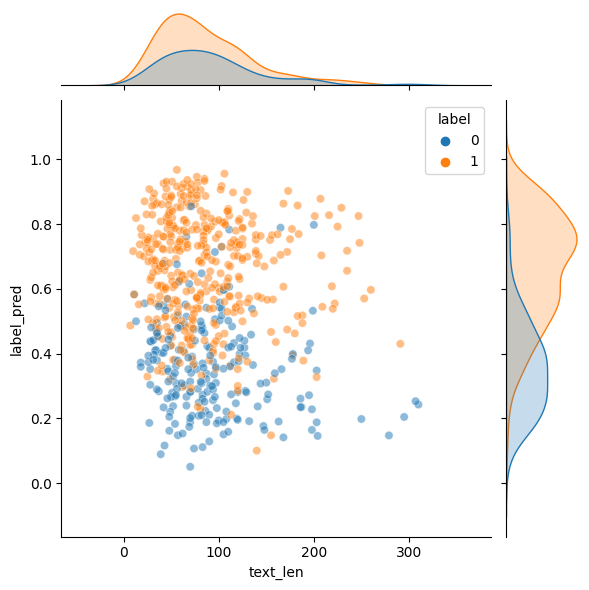

In [20]:
joint_plot = sns.jointplot(test, x="text_len", y="label_pred", hue="label", alpha=0.5)
joint_plot.figure.savefig("predictionsPlot.png")

In [21]:
def evaluate_thresholds(y_true, y_pred):
    """
    This function evaluates different thresholds for binarizing predicted values.
    It returns the balanced accuracy, f1 score and accuracy for each threshold value.

    Parameters:
    y_true (numpy array): The true binary labels (0 or 1).
    y_pred (numpy array): The predicted probabilities between 0 and 1.

    Returns:
    thresholds (numpy array): The different threshold values that were tested.
    balanced_accs (numpy array): The balanced accuracy for each threshold.
    f1_scores (numpy array): The f1 score for each threshold.
    accuracies (numpy array): The accuracy for each threshold.
    """
    thresholds = np.linspace(y_pred.min(), y_pred.max(), 101)
    balanced_accs = []
    f1_scores = []
    accuracies = []

    for threshold in thresholds:
        y_pred_bin = np.where(y_pred > threshold, 1, 0)
        balanced_accs.append(balanced_accuracy_score(y_true, y_pred_bin))
        f1_scores.append(f1_score(y_true, y_pred_bin))
        accuracies.append(accuracy_score(y_true, y_pred_bin))

    return thresholds, balanced_accs, f1_scores, accuracies

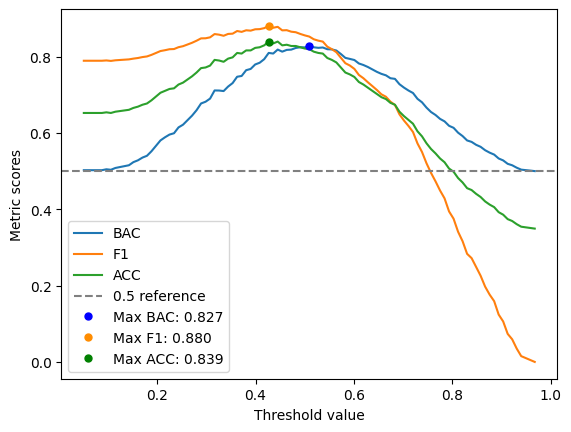

In [22]:
# Evaluate the predictions using different threshold values
thresholds, balanced_accs, f1_scores, accuracies = evaluate_thresholds(test['label'].to_numpy(), 
                                                                       test['label_pred'].to_numpy())

# Plot the evaluation metrics vs threshold value
fig, ax = plt.subplots()
ax.plot(thresholds, balanced_accs, label='BAC')
ax.plot(thresholds, f1_scores, label='F1')
ax.plot(thresholds, accuracies, label='ACC')

# Add a reference line at y=0.5
ax.axhline(y=0.5, color='gray', linestyle='--', label='0.5 reference')

# Add a dot on the highest value of each line and print the max value
max_balanced_acc = max(balanced_accs)
max_f1_score = max(f1_scores)
max_accuracy = max(accuracies)
ax.plot(thresholds[balanced_accs.index(max_balanced_acc)], max_balanced_acc, 'o', markersize=5, color='blue',
        label=f'Max BAC: {max_balanced_acc:.3f}')
ax.plot(thresholds[f1_scores.index(max_f1_score)], max_f1_score, 'o', markersize=5, color='darkorange',
        label=f'Max F1: {max_f1_score:.3f}')
ax.plot(thresholds[accuracies.index(max_accuracy)], max_accuracy, 'o', markersize=5, color='green',
        label=f'Max ACC: {max_accuracy:.3f}')

ax.set_xlabel("Threshold value")
ax.set_ylabel("Metric scores")
ax.legend(loc='best')
plt.savefig('measuresPerThresholdWithMax.png')
plt.show()

AL FINAL HAY QUE HACER UN PREDICT CON EL test.csv, AJUSTANDO EL MODELO CON TODOS LOS DATOS DE ENTRENAMIENTO

Lo que he hecho arriba está muy bien para ver qué tal funciona, pero estoy entrenando el modelo solo con 80% de los datos etiquetados que nos dan para poder validar qué tal está funcionando.

Los datos de `test.csv` nos los dan sin etiquetar, así que hay que entrenar el modelo con todos los datos de `train.csv` para generar nuestras predicciones finales. La forma de validar esto será generar el `predictions.json` y subirlo a la plataforma.

## ENTREGA

In [15]:
import pandas as pd
import numpy as np
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, f1_score, accuracy_score
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub
from matplotlib import pyplot as plt
import seaborn as sns

In [16]:
#load full train and test datasets
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# Add description length to the dataset
df_train["text_len"] = df_train["text"].str.len()

df_train

,train_idx,text,label,label_text,text_len
0,0,i really do recommend this to anyone in need o...,1,positive,60
1,1,very good every day camera fits nicely in the ...,1,positive,89
2,2,"but , dollar for dollar , this dvd player is p...",1,positive,72
3,3,i got this phone yesterday and didn ' t find a...,1,positive,69
4,4,1 ) price gb of storage,1,positive,23
...,...,...,...,...,...
3011,3011,"as for itunes , i don ' t find it to be as goo...",1,positive,124
3012,3012,"i have not played with all the features yet , ...",1,positive,99
3013,3013,applications it has lots of applications and t...,1,positive,126
3014,3014,battery non issue,1,positive,17


In [17]:
# Require numpy arrays from the datasets for later computations
X_train = df_train['text'].to_numpy()
y_train = df_train['label'].to_numpy()
X_test = df_test['text'].to_numpy()

In [18]:
# Bert preprocessing and pre-trained model
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name="BERT_preprocess")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", name="BERT_encoder")

In [19]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [20]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 BERT_preprocess (KerasLayer)   {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [21]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [22]:
model.fit(X_train, y_train, epochs=20, batch_size = 32)

Epoch 1/20
95/95 [==============================] - 391s 4s/step - loss: 0.6478 - accuracy: 0.6412
Epoch 2/20
95/95 [==============================] - 365s 4s/step - loss: 0.6102 - accuracy: 0.6631
Epoch 3/20
95/95 [==============================] - 376s 4s/step - loss: 0.5955 - accuracy: 0.6860
Epoch 4/20
95/95 [==============================] - 392s 4s/step - loss: 0.5686 - accuracy: 0.7145
Epoch 5/20
95/95 [==============================] - 410s 4s/step - loss: 0.5504 - accuracy: 0.7278
Epoch 6/20
95/95 [==============================] - 385s 4s/step - loss: 0.5350 - accuracy: 0.7407
Epoch 7/20
95/95 [==============================] - 367s 4s/step - loss: 0.5225 - accuracy: 0.7454
Epoch 8/20
95/95 [==============================] - 371s 4s/step - loss: 0.5158 - accuracy: 0.7543
Epoch 9/20
95/95 [==============================] - 368s 4s/step - loss: 0.5099 - accuracy: 0.7576
Epoch 10/20
95/95 [==============================] - 361s 4s/step - loss: 0.5018 - accuracy: 0.7706
Epoch 11/

In [23]:
y_predicted = model.predict(X_test)
y_predicted_flatenned = y_predicted.flatten()

24/24 [==============================] - 94s 4s/step


In [37]:
# Print 10 most positive descriptions
for i in range(10):
    print(X_test[np.where(y_predicted_flatenned == sorted(y_predicted_flatenned, reverse=True)[i])])

['i got this for christmas , and it is a great gift']
['great quality picture and features']
['the pictures are uniformly excellent and color rendering is perfect']
['the great and versatile ipod']
['versatile and stylish']
['i received this item for christmas and it has met and exceeded all my standards']
['i have the software working fine now and the mp3 player is fantastic']
['the ss body is wonderful , feels high quality']
['putting in mp3 player , lots of games and application to download']
['the battery recharges raul fast and the recharger thingy that comes with is real nice']


In [38]:
# Print 10 most positive descriptions
for i in range(10):
    print(X_test[np.where(y_predicted_flatenned == sorted(y_predicted_flatenned)[i])])

['buying software that can not be installed normally and being put into the position of having a non working computer']
['also , diapers tend to stay in the middle , causing the pail to get backed up']
['but if i installed either one of these norton products , neither works after installation ?']
['i tried to call norton , and the only numbers they list on their sites are either for non tech customer service ( tried this one and hung up after 75 minute of muzak ) or they have a 30 tech support number']
["both of the problem dvd 's would repeatedly freeze during playback , while the counter on the player kept going"]
['6 ) the case occludes the display screen when it is closed']
["next , the big reason not to buy any norton product if there 's a problem with it , norton charges 30 to even tell them about it"]
["the electronic speed control is not doing it ' s job and the router begins to speed up and slow down at will"]
['because steve jobs is a twisted individual and he made sure that 

In [25]:
y_predicted_flatenned

array([0.7098175 , 0.5533273 , 0.88450027, 0.8316175 , 0.8590526 ,
       0.8159018 , 0.31522012, 0.42571643, 0.6276557 , 0.8489358 ,
       0.788535  , 0.3889151 , 0.26510668, 0.84301174, 0.7904847 ,
       0.90163046, 0.4000092 , 0.50468546, 0.8163722 , 0.46293202,
       0.8919591 , 0.7579541 , 0.46269983, 0.7973956 , 0.84820145,
       0.2082802 , 0.72812605, 0.23916657, 0.7325716 , 0.7576101 ,
       0.3686539 , 0.40503857, 0.6356374 , 0.9757832 , 0.26397967,
       0.65283656, 0.7222087 , 0.684924  , 0.45967597, 0.3512974 ,
       0.14763665, 0.24349396, 0.12877862, 0.7674656 , 0.53915197,
       0.93033236, 0.15275978, 0.6700925 , 0.7296758 , 0.18821083,
       0.60503316, 0.24847071, 0.9041024 , 0.78904915, 0.3324178 ,
       0.25558516, 0.5543474 , 0.6717207 , 0.78192073, 0.2745595 ,
       0.2778863 , 0.5652339 , 0.31095904, 0.7058536 , 0.25616726,
       0.8819514 , 0.587659  , 0.49575084, 0.8838787 , 0.5847519 ,
       0.6098108 , 0.42768544, 0.77797216, 0.12821639, 0.52235

In [52]:
def dic_values(x):
    if(x <= 0.5):
        return 0
    else:
        return 1

y_predicted_labels = pd.Series(y_predicted_flatenned).map(dic_values)
y_predicted_labels

0      1
1      1
2      1
3      1
4      1
      ..
749    1
750    0
751    0
752    1
753    1
Length: 754, dtype: int64

In [114]:
y_predicted_labels.to_json(indent = 1).replace("\n", "")

'{ "0":1, "1":1, "2":1, "3":1, "4":1, "5":1, "6":0, "7":0, "8":1, "9":1, "10":1, "11":0, "12":0, "13":1, "14":1, "15":1, "16":0, "17":1, "18":1, "19":0, "20":1, "21":1, "22":0, "23":1, "24":1, "25":0, "26":1, "27":0, "28":1, "29":1, "30":0, "31":0, "32":1, "33":1, "34":0, "35":1, "36":1, "37":1, "38":0, "39":0, "40":0, "41":0, "42":0, "43":1, "44":1, "45":1, "46":0, "47":1, "48":1, "49":0, "50":1, "51":0, "52":1, "53":1, "54":0, "55":0, "56":1, "57":1, "58":1, "59":0, "60":0, "61":1, "62":0, "63":1, "64":0, "65":1, "66":1, "67":0, "68":1, "69":1, "70":1, "71":0, "72":1, "73":0, "74":1, "75":1, "76":1, "77":0, "78":1, "79":1, "80":1, "81":0, "82":1, "83":1, "84":1, "85":1, "86":0, "87":1, "88":0, "89":1, "90":1, "91":1, "92":1, "93":1, "94":1, "95":1, "96":1, "97":1, "98":0, "99":1, "100":0, "101":0, "102":1, "103":1, "104":0, "105":1, "106":1, "107":0, "108":1, "109":1, "110":0, "111":0, "112":1, "113":1, "114":0, "115":1, "116":1, "117":1, "118":1, "119":1, "120":0, "121":1, "122":1, 

In [122]:
import ast
preds = {'target': ast.literal_eval(y_predicted_labels.to_json(indent = 1).replace("\n", ""))}
print(preds)

{'target': {'0': 1, '1': 1, '2': 1, '3': 1, '4': 1, '5': 1, '6': 0, '7': 0, '8': 1, '9': 1, '10': 1, '11': 0, '12': 0, '13': 1, '14': 1, '15': 1, '16': 0, '17': 1, '18': 1, '19': 0, '20': 1, '21': 1, '22': 0, '23': 1, '24': 1, '25': 0, '26': 1, '27': 0, '28': 1, '29': 1, '30': 0, '31': 0, '32': 1, '33': 1, '34': 0, '35': 1, '36': 1, '37': 1, '38': 0, '39': 0, '40': 0, '41': 0, '42': 0, '43': 1, '44': 1, '45': 1, '46': 0, '47': 1, '48': 1, '49': 0, '50': 1, '51': 0, '52': 1, '53': 1, '54': 0, '55': 0, '56': 1, '57': 1, '58': 1, '59': 0, '60': 0, '61': 1, '62': 0, '63': 1, '64': 0, '65': 1, '66': 1, '67': 0, '68': 1, '69': 1, '70': 1, '71': 0, '72': 1, '73': 0, '74': 1, '75': 1, '76': 1, '77': 0, '78': 1, '79': 1, '80': 1, '81': 0, '82': 1, '83': 1, '84': 1, '85': 1, '86': 0, '87': 1, '88': 0, '89': 1, '90': 1, '91': 1, '92': 1, '93': 1, '94': 1, '95': 1, '96': 1, '97': 1, '98': 0, '99': 1, '100': 0, '101': 0, '102': 1, '103': 1, '104': 0, '105': 1, '106': 1, '107': 0, '108': 1, '109': 1

In [124]:
import json
with open('predictions2.json', 'w') as f:
    json.dump(preds, f, indent = 1)

In [83]:
with open('predicted_labels.csv', 'w') as f:
    y_predicted_labels.values.tofile(file = f, sep =',')